In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan

import arviz as az

import nest_asyncio
nest_asyncio.apply()

## The Problem and the Data

Event-related potentials (ERPs) allow scientists to observe electrophysiological responses in the brain measured by means of electroencephalography (EEG). These responses are typically time-locked to a specific event (i.e., the presentation of a stimulus). 

A very robust ERP effect in the study of language is the so-called N400. Words with low predictability are accompanied by an N400 effect in comparison with highly predictable words. The N400 is a relative negativity that peaks around 300-500 ms after word onset over central parietal scalp sites (see Kutas and Federmeier 2011 for a review). The N400 effect is illustrated below:

Predictability is typically measured via a *cloze task*. In language teaching, a *cloze* is a text from which words are removed and replaced with placeholders (e.g., space). The task is to fill each space with a suitable word.


We will use the data set from the replication study of Nieuwland et al. (2018) to the participants from the Edinburgh lab. 

Participants were presented with sentences like:
- The day was breezy so the boy went outside to fly a kite.
- The day was breezy so the boy went outside to fly an airplane.

We are going to focus on the N400 event-related potential (ERP) elicited at the final nouns in the experimental stimuli. In the example above, the final noun "kite" has higher predictability than ‘airplane,’ and thus we would expect a more negative signal in "airplane" in (b) in comparison with "kite" in (a).


We load the subset of the dataset below:

In [5]:
data = pd.read_csv('eeg_data.csv', header=0, sep=';')
data.head()

,subj,cloze,item,n400,cloze_ans,N
0,1,0.00,1,7.08,0,44
1,1,0.03,2,-0.68,1,44
2,1,1.00,3,1.39,44,44
3,1,0.93,4,22.78,41,44
4,1,0.00,5,1.61,0,44


In [ ]:
### Inspect some data
sns.histplot(data.n400, color='maroon', alpha=0.7)

## Complete Pooling Model

We start with the simplest mode which makes the following assumptions:

1. The EEG averages for the N400 spatiotemporal window are normally distributed.
2. There is a linear relationship between cloze probability and the EEG signal for the trial.
3. The observations are exchangeable.

In [ ]:
program_code = """
data {
    int<lower=1> N;
    vector[N] signal;
    vector[N] cloze;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    real beta;
}

model {
    // Priors
    sigma ~ cauchy(0, 5);
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Likelihood
    // Our code here
}

generated quantities {
    vector[N] pred_signal;
    for (n in 1:N) {
        pred_signal[n] = normal_rng(alpha + cloze[n] * beta, sigma);
    }
}
"""

In [6]:
# Prepare data in Stan friendly format
data_dict = {
    'N': data.shape[0],
    'signal': data.n400.values,
    'cloze': data.cloze.values,
}

# Compile model
complete_pooling_model = stan.build(program_code, data=data_dict)


# Sample 4 x 1000 random draws from the posterior
complete_pooling_fit = complete_pooling_model.sample(num_chains=4, num_warmup=1000, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   8% (601/8000)
Sampling:  11% (900/8000)
Sampling:  16% (1300/8000)
Sampling:  20% (1600/8000)
Sampling:  25% (2000/8000)
Sampling:  30% (2400/8000)
Sampling:  35% (2800/8000)
Sampling:  40% (3200/8000)
Sampling:  55% (4400/8000)
Sampling:  71% (5700/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000571 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.71 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00049 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.9 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000973 seconds
  1000 trans

In [7]:
complete_pooling_results = complete_pooling_fit.to_frame()

In [8]:
complete_pooling_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta,...,pred_signal.2854,pred_signal.2855,pred_signal.2856,pred_signal.2857,pred_signal.2858,pred_signal.2859,pred_signal.2860,pred_signal.2861,pred_signal.2862,pred_signal.2863
draws,,,,,,,,,,,,,,,,,,,,,
0,-8501.142848,0.955167,0.476264,2.0,3.0,0.0,8501.750919,11.851047,3.158531,1.373508,...,5.795825,13.935124,-5.221291,-6.868044,12.666196,13.514207,13.774450,-2.515232,8.862274,11.410338
1,-8500.462451,0.844724,0.464315,3.0,7.0,0.0,8502.816635,11.841911,2.462769,1.958939,...,10.406832,-8.990503,-5.947804,-10.620415,4.244179,19.041381,-15.644820,18.014550,8.917994,-5.411375
2,-8500.166874,0.991860,0.442527,2.0,3.0,0.0,8500.662489,11.753534,2.245942,2.779699,...,-13.731648,9.480086,-2.390309,11.926227,-4.532152,4.343478,11.446487,-3.871878,2.751452,-3.669257
3,-8503.136761,0.710883,0.409559,3.0,15.0,0.0,8506.487801,11.615473,2.197209,3.449165,...,-3.461711,11.472416,7.131175,-7.771386,-2.192382,24.536903,0.999922,-5.493321,12.950226,9.418814
4,-8500.901614,0.732410,0.476264,3.0,15.0,0.0,8504.305405,11.568319,2.660283,2.019052,...,-7.976294,13.259320,21.159392,11.099391,-12.236379,-4.737981,4.777036,11.203478,12.955080,9.878795


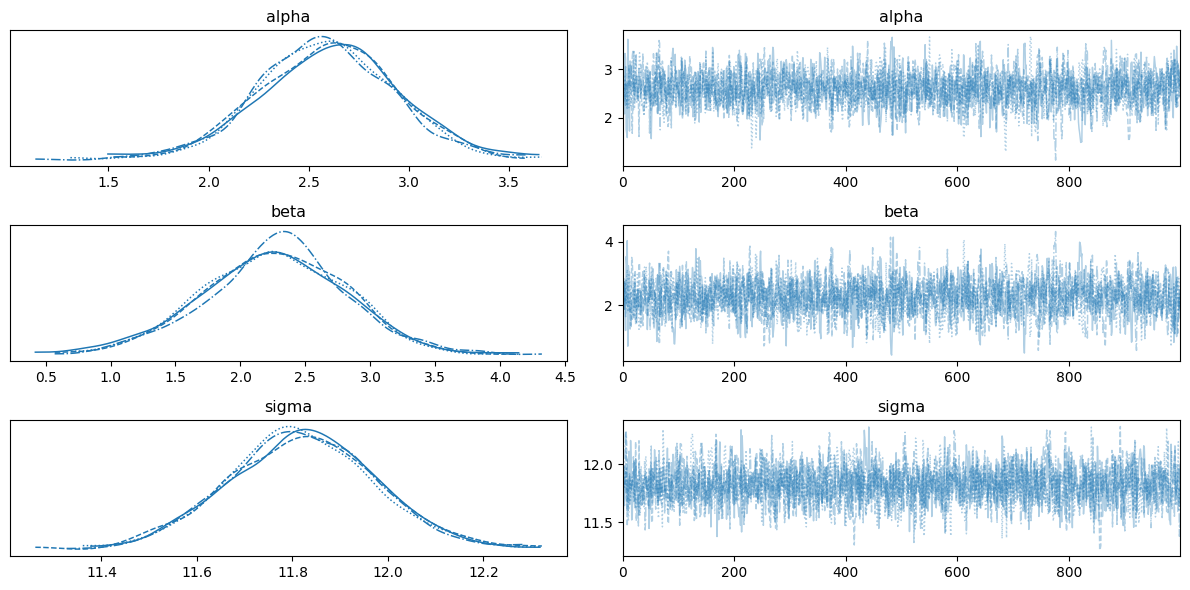

In [9]:
_ = az.plot_trace(complete_pooling_fit, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()

In [10]:
az.summary(complete_pooling_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,11.821,0.156,11.529,12.121,0.003,0.002,2408.0,2408.0,1.0
alpha,2.593,0.345,1.945,3.243,0.008,0.006,1855.0,1915.0,1.0
beta,2.263,0.552,1.172,3.262,0.013,0.009,1827.0,1982.0,1.0
pred_signal[0],2.803,11.816,-20.102,24.328,0.187,0.138,4009.0,3590.0,1.0
pred_signal[1],2.808,11.710,-18.083,25.053,0.185,0.134,4027.0,4100.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_signal[2858],4.463,11.937,-16.077,29.451,0.198,0.142,3652.0,3379.0,1.0
pred_signal[2859],4.635,11.713,-17.027,26.339,0.187,0.132,3940.0,3901.0,1.0
pred_signal[2860],2.540,12.128,-20.262,25.446,0.190,0.135,4055.0,3813.0,1.0
pred_signal[2861],5.092,11.832,-15.577,28.490,0.183,0.134,4160.0,3721.0,1.0


<Axes: xlabel='n400', ylabel='Density'>

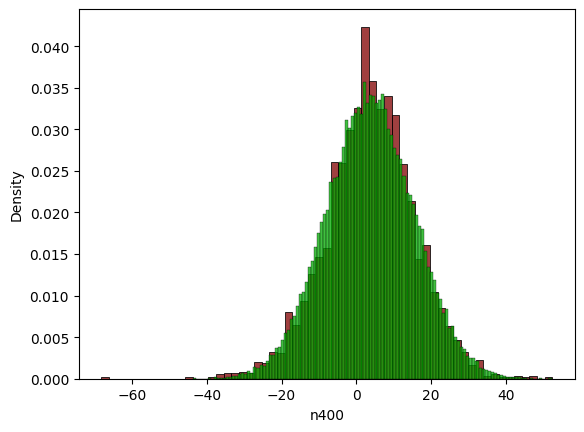

In [11]:
# Marginal check
sns.histplot(data.n400, color='maroon', stat='density')
sns.histplot(complete_pooling_results.iloc[:20, 10:].values.flatten(), stat='density', color='#00AA00')

In [ ]:
### Conditional check?
### Your code here

Text(0.5, 1.0, 'Complete Pooling: Generative Performance')

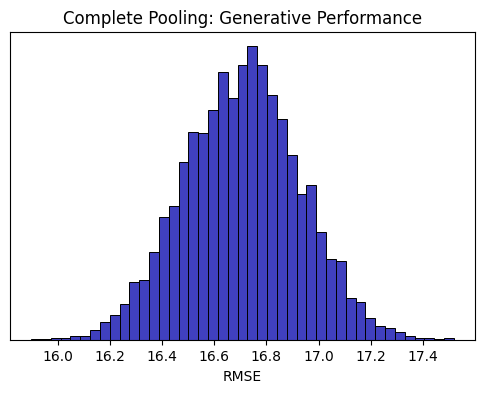

In [13]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(np.sqrt(np.mean((complete_pooling_results.iloc[:, 10:] - data.n400.values)**2, axis=1)), color='#0000AA', ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('RMSE', fontsize=10)
ax.set_title('Complete Pooling: Generative Performance')

## No Pooling

The no pooling approach will simply fit the same model independently to each participant.

In [ ]:
program_code = """
data {
    int<lower=1> N;
    int<lower=1> J;
    vector[N] signal;
    vector[N] cloze;
    array[N] int<lower=1, upper=J> mask;
}

parameters {
    vector[J] alpha;
    vector[J] beta;
    real<lower=0> sigma;
}

model {
    // Priors
    sigma ~ cauchy(0, 5);
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Likelihood
    // Our code here
}

generated quantities {
    vector[N] pred_signal;
    for (n in 1:N) {
        pred_signal[n] = normal_rng(alpha[mask[n]] + cloze[n] * beta[mask[n]], sigma);
    }
}
"""

In [14]:
data.subj.values

array([ 1,  1,  1, ..., 37, 37, 37])

In [133]:
# Prepare data in Stan friendly format
data_dict = {
    'N': data.shape[0],
    'J': np.unique(data.subj).shape[0],
    'signal': data.n400.values,
    'cloze': data.cloze.values,
    'mask': data.subj.values
 
}

# Compile model
no_pooling_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2500 random draws from the posterior
no_pooling_fit = no_pooling_model.sample(num_chains=4, num_warmup=1000, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  54% (4300/8000)
Sampling:  70% (5600/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sa

In [139]:
results = no_pooling_fit.to_frame()

<Axes: xlabel='n400', ylabel='Density'>

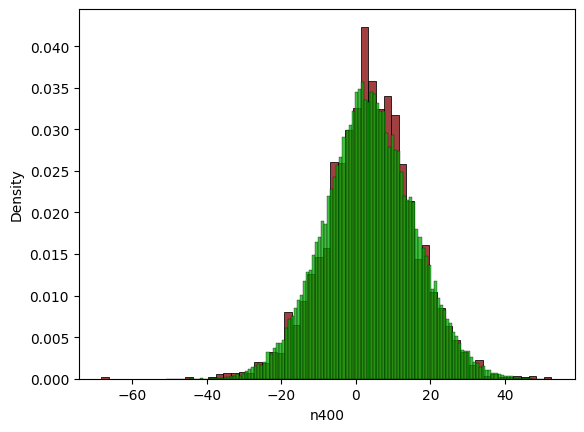

In [140]:
# Marginal check
sns.histplot(data.n400, color='maroon', stat='density')
sns.histplot(results.iloc[:20, 10:].values.flatten(), stat='density', color='#00AA00')

In [125]:
# Check conditional generative performance

## Partial Pooling Models

We now illustrate different types of hierarchical models that represent the middle ground between complete pooling and no-pooling models.

### Varying intercepts model

In [ ]:
program_code = """
data {
    int<lower=1> N;
    int<lower=1> J;
    vector[N] signal;
    vector[N] cloze;
    array[N] int<lower=1, upper=J> mask;
}

parameters {
    real<lower=0> sigma;
    real<lower=0> tau;
    real alpha;
    real beta;
    vector[J] u;
}

model {
    // Level 1 priors
    sigma ~ cauchy(0, 5);
    tau ~ cauchy(0, 5);
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Level 2 prior
    u ~ normal(0, tau);

    // Likelihood
    // Our code here
}
"""

In [ ]:
# Prepare data in Stan friendly format
data_dict = {
    'N': data.shape[0],
    'J': np.unique(data.subj).shape[0],
    'signal': data.n400.values,
    'cloze': data.cloze.values,
    'mask': data.subj.values
 
}

# Compile model
partial_pooling_model1 = stan.build(program_code, data=data_dict)


# Fit model
partial_pooling_fit1 = partial_pooling_model1.sample(num_chains=4, num_warmup=1000, num_samples=1000)

In [9]:
summary = az.summary(partial_pooling_fit1)

In [ ]:
summary

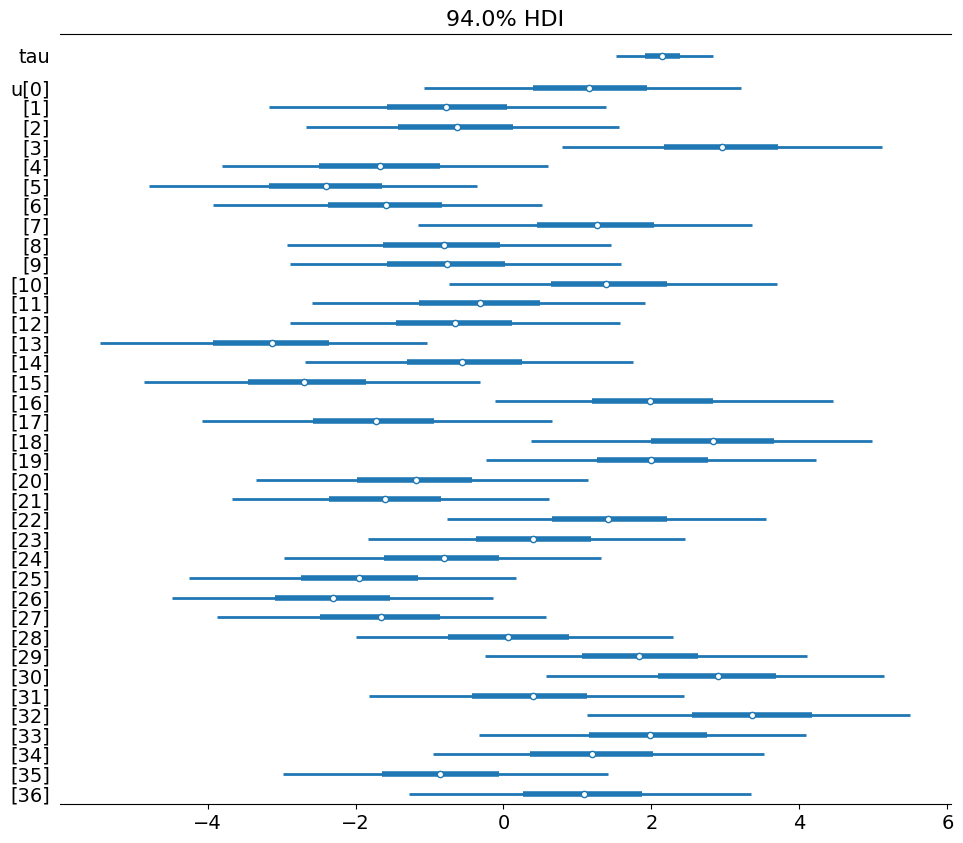

In [11]:
axes = az.plot_forest(
    partial_pooling_fit1,
    var_names=['u'],
    filter_vars='like',
    linewidth=2,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(11.5, 10),
)

### Varying intercepts and slopes model

In [ ]:
program_code = """
data {
    // Your code here
}

parameters {
    // Your code here
}

model {
    // Level 1 priors
    // Your code here

    // Level 2 prior
    // Your code here

    // Likelihood
    // Your code here
}


generated quantities {
    // Your code here
}
"""

In [ ]:
### Model fitting


### Model validation